## 任务说明

- 任务主题：论文代码统计，统计所有论文出现代码的相关统计；
- 任务内容：使用正则表达式统计代码连接、页数和图表数据；
- 任务成果：学习正则表达式统计；

## 数据处理步骤

在原始arxiv数据集中作者经常会在论文的`comments`或`abstract`字段中给出具体的代码链接，所以我们需要从这些字段里面找出代码的链接。

- 确定数据出现的位置；
- 使用正则表达式完成匹配；
- 完成相关的统计；

## 正则表达式

正则表达式(regular expression)描述了一种字符串匹配的模式（pattern），可以用来检查一个串是否含有某种子串、将匹配的子串替换或者从某个串中取出符合某个条件的子串等。

#### 普通字符：大写和小写字母、所有数字、所有标点符号和一些其他符号

| 字符       | 描述                                                         |
| ---------- | ------------------------------------------------------------ |
| **[ABC]**  | 匹配 [...] 中的所有字符，例如 [aeiou] 匹配字符串 "google runoob taobao" 中所有的 e o u a 字母。 |
| **[^ABC]** | 匹配除了 **[...]** 中字符的所有字符，例如 **[^aeiou]** 匹配字符串 "google runoob taobao" 中除了 e o u a 字母的所有字母。 |
| **[A-Z]**  | [A-Z] 表示一个区间，匹配所有大写字母，[a-z] 表示所有小写字母。 |
| .          | 匹配除换行符（\n、\r）之外的任何单个字符，相等于 **[^\n\r]**。 |
| **[\s\S]** | 匹配所有。\s 是匹配所有空白符，包括换行，\S 非空白符，包括换行。 |
| **\w**     | 匹配字母、数字、下划线。等价于 [A-Za-z0-9_]                  |

#### 特殊字符：有特殊含义的字符

| 特别字符 | 描述                                                         |
| :------- | :----------------------------------------------------------- |
| ( )      | 标记一个子表达式的开始和结束位置。子表达式可以获取供以后使用。要匹配这些字符，请使用 \( 和 \)。 |
| *        | 匹配前面的子表达式零次或多次。要匹配 * 字符，请使用 \*。     |
| +        | 匹配前面的子表达式一次或多次。要匹配 + 字符，请使用 \+。     |
| .        | 匹配除换行符 \n 之外的任何单字符。要匹配 . ，请使用 \. 。    |
| [        | 标记一个中括号表达式的开始。要匹配 [，请使用 \[。            |
| ?        | 匹配前面的子表达式零次或一次，或指明一个非贪婪限定符。要匹配 ? 字符，请使用 \?。 |
| \        | 将下一个字符标记为或特殊字符、或原义字符、或向后引用、或八进制转义符。例如， 'n' 匹配字符 'n'。'\n' 匹配换行符。序列 '\\' 匹配 "\"，而 '\(' 则匹配 "("。 |
| ^        | 匹配输入字符串的开始位置，除非在方括号表达式中使用，当该符号在方括号表达式中使用时，表示不接受该方括号表达式中的字符集合。要匹配 ^ 字符本身，请使用 \^。 |
| {        | 标记限定符表达式的开始。要匹配 {，请使用 \{。                |
| \|       | 指明两项之间的一个选择。要匹配 \|，请使用 \|。               |

#### 限定符

| 字符  | 描述                                                         |
| :---- | :----------------------------------------------------------- |
| *     | 匹配前面的子表达式零次或多次。例如，zo* 能匹配 "z" 以及 "zoo"。* 等价于{0,}。 |
| +     | 匹配前面的子表达式一次或多次。例如，'zo+' 能匹配 "zo" 以及 "zoo"，但不能匹配 "z"。+ 等价于 {1,}。 |
| ?     | 匹配前面的子表达式零次或一次。例如，"do(es)?" 可以匹配 "do" 、 "does" 中的 "does" 、 "doxy" 中的 "do" 。? 等价于 {0,1}。 |
| {n}   | n 是一个非负整数。匹配确定的 n 次。例如，'o{2}' 不能匹配 "Bob" 中的 'o'，但是能匹配 "food" 中的两个 o。 |
| {n,}  | n 是一个非负整数。至少匹配n 次。例如，'o{2,}' 不能匹配 "Bob" 中的 'o'，但能匹配 "foooood" 中的所有 o。'o{1,}' 等价于 'o+'。'o{0,}' 则等价于 'o*'。 |
| {n,m} | m 和 n 均为非负整数，其中n <= m。最少匹配 n 次且最多匹配 m 次。例如，"o{1,3}" 将匹配 "fooooood" 中的前三个 o。'o{0,1}' 等价于 'o?'。请注意在逗号和两个数之间不能有空格。 |

## 具体代码实现以及讲解

首先我们来统计论文页数，也就是在`comments`字段中抽取pages和figures和个数，首先完成字段读取。


In [1]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

In [3]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data

data = readArxivFile('arxiv-metadata-oai-2019.json', ['id', 'abstract', 'categories', 'comments'])


对pages进行抽取：

In [4]:
# 使用正则表达式匹配，XX pages
data['pages'] = data['comments'].apply(lambda x: re.findall('[1-9][0-9]* pages', str(x)))

# 筛选出有pages的论文
data = data[data['pages'].apply(len) > 0]

# 由于匹配得到的是一个list，如['19 pages']，需要进行转换
data['pages'] = data['pages'].apply(lambda x: float(x[0].replace(' pages', '')))

对pages进行统计，统计结果如下：论文平均的页数为17页，75%的论文在22页以内，最长的论文有11232页。

In [5]:
data['pages'].describe().astype(int)

count    80696
mean        18
std         20
min          1
25%          9
50%         14
75%         24
max       1958
Name: pages, dtype: int32

接下来按照分类统计论文页数，选取了论文的第一个类别的主要类别：

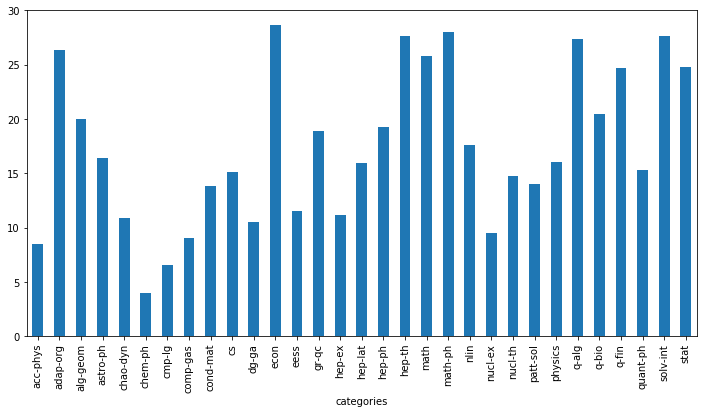

In [6]:
# 选择主要类别
data['categories'] = data['categories'].apply(lambda x: x.split(' ')[0])
data['categories'] = data['categories'].apply(lambda x: x.split('.')[0])

# 每类论文的平均页数
plt.figure(figsize=(12, 6))
data.groupby(['categories'])['pages'].mean().plot(kind='bar')


接下来对论文图表个数进行抽取：

In [7]:
data['figures'] = data['comments'].apply(lambda x: re.findall('[1-9][0-9]* figures', str(x)))
data = data[data['figures'].apply(len) > 0]
data['figures'] = data['figures'].apply(lambda x: float(x[0].replace(' figures', '')))

最后我们对论文的代码链接进行提取，为了简化任务我们只抽取github链接：


In [8]:
# 筛选包含github的论文
data_with_code = data[
    (data.comments.str.contains('github')==True)|
                      (data.abstract.str.contains('github')==True)
]
data_with_code['text'] = data_with_code['abstract'].fillna('') + data_with_code['comments'].fillna('')

# 使用正则表达式匹配论文
pattern = '[a-zA-z]+://github[^\s]*'
data_with_code['code_flag'] = data_with_code['text'].str.findall(pattern).apply(len)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


并对论文按照类别进行绘图：

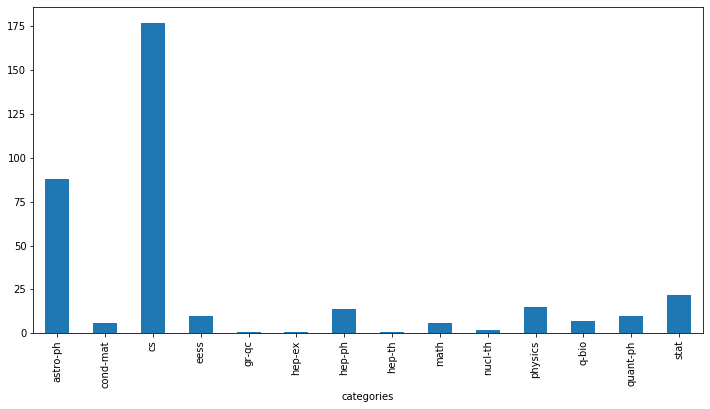

In [9]:
data_with_code = data_with_code[data_with_code['code_flag'] == 1]
plt.figure(figsize=(12, 6))
data_with_code.groupby(['categories'])['code_flag'].count().plot(kind='bar')